In [ ]:
import csv
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas as pd
import numpy as np
import os

import scipy.stats

import statsmodels.stats.multitest
fdr = statsmodels.stats.multitest.fdrcorrection

import stats_utils, plot_utils

get_moving_average = stats_utils.get_moving_average
mixed_effect_model = stats_utils.mixed_effect_model

# this should be your main project folder (startingblurry), one level up from "analysis"
root = os.path.dirname(os.getcwd())


#### Load all the data

In [11]:
n_epochs = 300;
n_conds = 3;
trials = np.arange(1,11);
n_trials = len(trials)

# the first dimension of these arrays is the condition
# (image type)
dat_trn_bw = np.zeros((n_conds, len(trials), n_epochs),dtype=float)
dat_val_bw = np.zeros((n_conds, len(trials), n_epochs),dtype=float)

dat_trn_col = np.zeros((n_conds, len(trials), n_epochs),dtype=float)
dat_val_col = np.zeros((n_conds, len(trials), n_epochs),dtype=float)


for ti, tt in enumerate(trials):
    
    filename = os.path.join(root, 'trials', 'BW', \
                        '%d'%tt, 'trainingLogBWNoBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[0,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[0,ti,:] = np.array(dat)[0:n_epochs,2]
    assert(np.max(dat_val_bw[0,ti,:])==np.array(dat['Best Val Acc'])[-1])
    
    filename = os.path.join(root, 'trials', 'BW', \
                        '%d'%tt, 'trainingLogBWLinearBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[1,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[1,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'BW', \
                        '%d'%tt, 'trainingLogBWNonLinearBlurModel2.csv')    
    dat = pd.read_csv(filename)
    dat_trn_bw[2,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_bw[2,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'Colored', \
                        '%d'%tt, 'trainingLogColoredNoBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[0,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[0,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'Colored', \
                        '%d'%tt, 'trainingLogColoredLinearBlurModel.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[1,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[1,ti,:] = np.array(dat)[0:n_epochs,2]
    
    filename = os.path.join(root, 'trials', 'Colored', \
                        '%d'%tt, 'trainingLogColoredNonLinearBlurModel2.csv')    
    dat = pd.read_csv(filename)
    dat_trn_col[2,ti,:] = np.array(dat)[0:n_epochs,1]
    dat_val_col[2,ti,:] = np.array(dat)[0:n_epochs,2]

#### make a folder for saving figure files

In [12]:
if not os.path.exists(os.path.join(root, 'analysis', 'figures')):
    os.makedirs(os.path.join(root, 'analysis', 'figures'))

#### make some names and colors for the plots

In [13]:
cond_names = ['noblur', 'blur1', 'blur2']
gray_color = cm.gray(np.linspace(0,1,4))[2:3,:]
blue_color = cm.Blues(np.linspace(0,1,4))[2:3,:]
green_color = cm.Greens(np.linspace(0,1,4))[2:3,:]
cond_colors = np.concatenate([gray_color, blue_color, green_color], axis=0)

#### perform smoothing, compute estimated learning rate
learning rate = approximate slope of accuracy at each timepoint


In [14]:
# do smoothing over time, within each trial and each condition separately

window_size=20;

smoothed_trn_bw = np.array([[get_moving_average(dat_trn_bw[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])
smoothed_val_bw = np.array([[get_moving_average(dat_val_bw[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])
smoothed_trn_col = np.array([[get_moving_average(dat_trn_col[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])
smoothed_val_col = np.array([[get_moving_average(dat_val_col[cc,ii,:], window_size) \
                                   for ii in range(n_trials)] for cc in range(n_conds)])

n_epochs_smoothed = smoothed_trn_bw.shape[2]
# once the data is smoothed, the actual epoch corresponding to each datapt is different.
# we can get new epoch number by averaging the old epoch sequence
# epochs_smoothed = get_moving_average(np.arange(n_epochs), window_size)
epochs_smoothed = np.arange(n_epochs_smoothed)

# compute learning rate: difference in acc every epoch.
lr_trn_bw = np.diff(smoothed_trn_bw, axis=2)
lr_val_bw = np.diff(smoothed_val_bw, axis=2)
lr_trn_col = np.diff(smoothed_trn_col, axis=2)
lr_val_col = np.diff(smoothed_val_col, axis=2)

# smooth these values over time (again)
lr_window_size = 20;

lr_trn_bw_smoothed = np.array([[get_moving_average(lr_trn_bw[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
lr_val_bw_smoothed = np.array([[get_moving_average(lr_val_bw[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
lr_trn_col_smoothed = np.array([[get_moving_average(lr_trn_col[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
lr_val_col_smoothed = np.array([[get_moving_average(lr_val_col[cc,ii,:], window_size=lr_window_size) \
                            for ii in range(n_trials)] for cc in range(n_conds)])
# get the correct epoch numbers for smoothed learning rate estimates
epochs_lr_smoothed = np.arange(n_epochs_smoothed-1)+0.5
# epochs_lr_smoothed = get_moving_average(epochs_smoothed[0:-1], window_size=window_size)
n_epochs_lr_smoothed = len(epochs_lr_smoothed)

#### Mixed effects models
test for difference over multiple epochs, using sliding window

Note this cell is very slow, so I saved the results out to a .npy file

In [5]:
# pairwise comparisons: control vs blur 1, control vs blur 2, blur 1 vs blur 2
conds_compare = [[0,1], [0,2], [1,2]]

epoch_window_size=20
epoch_start_values = np.arange(0,n_epochs_smoothed-epoch_window_size,1)

epoch_ranges = [np.arange(ee, np.minimum(ee+epoch_window_size, n_epochs_smoothed)) \
                    for ee in epoch_start_values]
epoch_centers = [epochs_smoothed[int(np.mean(ee))] for ee in epoch_ranges]

coeffs_bw = np.zeros((len(epoch_start_values),3))
pvals_bw = np.zeros((len(epoch_start_values),3))

coeffs_col = np.zeros((len(epoch_start_values),3))
pvals_col = np.zeros((len(epoch_start_values),3))

coeffs_lr_bw = np.zeros((len(epoch_start_values)-1,3))
pvals_lr_bw = np.zeros((len(epoch_start_values)-1,3))

coeffs_lr_col = np.zeros((len(epoch_start_values)-1,3))
pvals_lr_col = np.zeros((len(epoch_start_values)-1,3))


for ee, epoch_range in enumerate(epoch_ranges):
    
    for cc, conds in enumerate(conds_compare):
    
        # black and white results
        coeff_condition, pval_condition =  mixed_effect_model(dat=smoothed_val_bw, \
                                                         conds_compare=conds, \
                                                         epoch_range=epoch_range)
        coeffs_bw[ee,cc] = coeff_condition
        pvals_bw[ee,cc] = pval_condition
        
        # colored results
        coeff_condition, pval_condition =  mixed_effect_model(dat=smoothed_val_col, \
                                                         conds_compare=conds, \
                                                          epoch_range=epoch_range)
        coeffs_col[ee,cc] = coeff_condition
        pvals_col[ee,cc] = pval_condition
        
        # learning rates
        if ee<len(epoch_ranges)-1:
            # black and white 
            coeff_condition, pval_condition =  mixed_effect_model(dat=lr_val_bw_smoothed, \
                                                             conds_compare=conds, \
                                                              epoch_range=epoch_range)
            coeffs_lr_bw[ee,cc] = coeff_condition
            pvals_lr_bw[ee,cc] = pval_condition
            
            # black and white 
            coeff_condition, pval_condition =  mixed_effect_model(dat=lr_val_col_smoothed, \
                                                             conds_compare=conds, \
                                                              epoch_range=epoch_range)
            coeffs_lr_col[ee,cc] = coeff_condition
            pvals_lr_col[ee,cc] = pval_condition


save_path = os.path.join(root, 'analysis', 'mixed_effects_model_results_exp1.npy')
np.save(save_path, {'coeffs_bw': coeffs_bw, \
                    'pvals_bw': pvals_bw, \
                    'coeffs_col': coeffs_col, \
                    'pvals_col': pvals_col, \
                    'coeffs_lr_bw': coeffs_lr_bw, \
                    'pvals_lr_bw': pvals_lr_bw, \
                    'coeffs_lr_col': coeffs_lr_col, \
                    'pvals_lr_col': pvals_lr_col, \
                    'epoch_centers': epoch_centers, \
                    'epoch_ranges': epoch_ranges, \
                    'conds_compare': conds_compare, 
                   }, allow_pickle=True)

#### If above cell already run, load result here

In [15]:
load_path = os.path.join(root, 'analysis', 'mixed_effects_model_results_exp1.npy')
result = np.load(load_path, allow_pickle=True).item()
pvals_bw = result['pvals_bw']
pvals_col = result['pvals_col']
pvals_lr_bw = result['pvals_lr_bw']
pvals_lr_col = result['pvals_lr_col']
epoch_ranges = result['epoch_ranges']
epoch_centers = result['epoch_centers']
epoch_centers_lr = epoch_centers[0:-1]
conds_compare = result['conds_compare']
cond_comparisons = ['%s vs %s'%(cond_names[1], cond_names[0]), \
                    '%s vs %s'%(cond_names[2], cond_names[0]), \
                    '%s vs %s'%(cond_names[1], cond_names[2]), ]


#### FDR correct all the p-values together

In [16]:
fdr_method = 'indep'
orig_size = pvals_bw.shape
mask_fdr_bw,pvals_fdr_bw = fdr(pvals_bw.ravel(), alpha=0.05, method=fdr_method)
mask_fdr_bw = np.reshape(mask_fdr_bw, orig_size)
mask_fdr_col,pvals_fdr_col = fdr(pvals_col.ravel(), alpha=0.05, method=fdr_method)
mask_fdr_col = np.reshape(mask_fdr_col, orig_size)

orig_size = pvals_lr_bw.shape
mask_fdr_lr_bw,pvals_fdr_lr_bw = fdr(pvals_lr_bw.ravel(), alpha=0.05, method=fdr_method)
mask_fdr_lr_bw = np.reshape(mask_fdr_lr_bw, orig_size)
mask_fdr_lr_col,pvals_fdr_lr_col = fdr(pvals_lr_col.ravel(), alpha=0.05, method=fdr_method)
mask_fdr_lr_col = np.reshape(mask_fdr_lr_col, orig_size)

#### Plot accuracy over time, overlaying test result significance

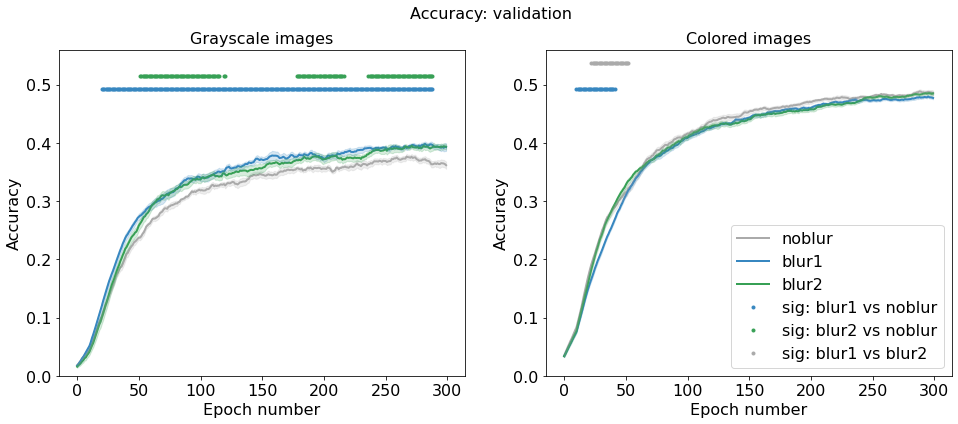

In [17]:
ylims = [0, 0.56]
ydist = ylims[1]-ylims[0]
sig_positions = ylims[0]+ydist*np.array([0.88, 0.92, 0.96])


plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(16)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)

for cc in range(n_conds):
   
    meanvals = np.mean(smoothed_val_bw[cc,:,:], axis=0)
    semvals = np.std(smoothed_val_bw[cc,:,:], axis=0)/np.sqrt(n_trials)
    
    plt.plot(epochs_smoothed, meanvals, label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
    plt.fill_between(epochs_smoothed, meanvals-semvals, meanvals+semvals,
            alpha=0.2, zorder=10, color=cond_colors[cc,:])


# sig_positions = [0.5, 0.52, 0.54]
comparison_colors = cond_colors[[1,2,0],:]
# loop over the different pairwise comparisons that we did
for ccpair in range(len(conds_compare)):
    
    # is_sig = np.where(pvals[ccpair,:]<0.05)[0]
    is_sig = np.where(mask_fdr_bw[:,ccpair])[0]
    plt.plot(np.array(epoch_centers)[is_sig], sig_positions[ccpair]*np.ones(np.shape(is_sig)), '.', \
             color=comparison_colors[ccpair,:],alpha=1, \
             label = 'sig: %s'%cond_comparisons[ccpair])

plt.ylim(ylims)
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
plt.title('Grayscale images')

plt.subplot(1,2,2)

for cc in range(n_conds):
   
    meanvals = np.mean(smoothed_val_col[cc,:,:], axis=0)
    semvals = np.std(smoothed_val_col[cc,:,:], axis=0)/np.sqrt(n_trials)
    
    plt.plot(epochs_smoothed, meanvals, label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
    plt.fill_between(epochs_smoothed, meanvals-semvals, meanvals+semvals,
            alpha=0.2, zorder=10, color=cond_colors[cc,:])


# sig_positions = [0.5, 0.52, 0.54]
comparison_colors = cond_colors[[1,2,0],:]
# loop over the different pairwise comparisons that we did
for ccpair in range(len(conds_compare)):
    
    # is_sig = np.where(pvals[ccpair,:]<0.05)[0]
    is_sig = np.where(mask_fdr_col[:,ccpair])[0]
    plt.plot(np.array(epoch_centers)[is_sig], sig_positions[ccpair]*np.ones(np.shape(is_sig)), '.', \
             color=comparison_colors[ccpair,:],alpha=1, \
             label = 'sig: %s'%cond_comparisons[ccpair])

plt.ylim(ylims)
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Colored images')

plt.suptitle('Accuracy: validation');

    
fn2save = os.path.join(root, 'analysis', 'figures', 'Ecoset_accuracy_both.pdf')
plt.savefig(fn2save)


#### Plot the learning rates

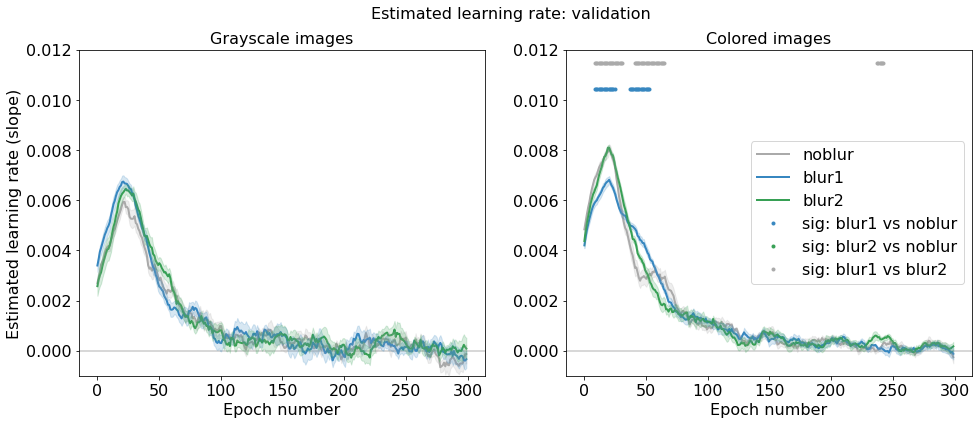

In [18]:
ylims = [-0.001, 0.012]
ydist = ylims[1]-ylims[0]
sig_positions = ylims[0]+ydist*np.array([0.88, 0.92, 0.96])


plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(16)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)

for cc in range(n_conds):
   
    meanvals = np.mean(lr_val_bw_smoothed[cc,:,:], axis=0)
    semvals = np.std(lr_val_bw_smoothed[cc,:,:], axis=0)/np.sqrt(n_trials)
    
    plt.plot(epochs_lr_smoothed, meanvals, label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
    plt.fill_between(epochs_lr_smoothed, meanvals-semvals, meanvals+semvals,
            alpha=0.2, zorder=10, color=cond_colors[cc,:])


# sig_positions = np.linspace(0.01, 0.011, 3)
comparison_colors = cond_colors[[1,2,0],:]
# loop over the different pairwise comparisons that we did
for ccpair in range(len(conds_compare)):
    
    # is_sig = np.where(pvals[ccpair,:]<0.05)[0]
    is_sig = np.where(mask_fdr_lr_bw[:,ccpair])[0]
    plt.plot(np.array(epoch_centers_lr)[is_sig], sig_positions[ccpair]*np.ones(np.shape(is_sig)), '.', \
             color=comparison_colors[ccpair,:],alpha=1, \
             label = 'sig: %s'%cond_comparisons[ccpair])
    
plt.axhline(0,color=[0.8, 0.8, 0.8], zorder=-10)
plt.ylim(ylims)
plt.xlabel('Epoch number')
plt.ylabel('Estimated learning rate (slope)')
# plt.legend(loc='lower right')
plt.title('Grayscale images')

plt.subplot(1,2,2)

for cc in range(n_conds):
   
    meanvals = np.mean(lr_val_col_smoothed[cc,:,:], axis=0)
    semvals = np.std(lr_val_col_smoothed[cc,:,:], axis=0)/np.sqrt(n_trials)
    
    plt.plot(epochs_lr_smoothed, meanvals, label = cond_names[cc], linewidth=2, color=cond_colors[cc,:])
    plt.fill_between(epochs_lr_smoothed, meanvals-semvals, meanvals+semvals,
            alpha=0.2, zorder=10, color=cond_colors[cc,:])


# sig_positions = np.linspace(0.01, 0.011, 3)
comparison_colors = cond_colors[[1,2,0],:]
# loop over the different pairwise comparisons that we did
for ccpair in range(len(conds_compare)):
    
    # is_sig = np.where(pvals[ccpair,:]<0.05)[0]
    is_sig = np.where(mask_fdr_lr_col[:,ccpair])[0]
    plt.plot(np.array(epoch_centers_lr)[is_sig], sig_positions[ccpair]*np.ones(np.shape(is_sig)), '.', \
             color=comparison_colors[ccpair,:],alpha=1, \
             label = 'sig: %s'%cond_comparisons[ccpair])

plt.axhline(0,color=[0.8, 0.8, 0.8], zorder=-10)
plt.ylim([-0.001, 0.012])
plt.xlabel('Epoch number')

plt.legend(loc='center right')
plt.title('Colored images')

plt.suptitle('Estimated learning rate: validation');

fn2save = os.path.join(root, 'analysis', 'figures', 'Ecoset_learningrates_both.pdf')
plt.savefig(fn2save)
